In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import seaborn as sns

import scanpy as sc
import palantir
from fa2 import ForceAtlas2
from sklearn.neighbors import NearestNeighbors
%matplotlib inline


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
np.random.seed(12345)
plt.rcParams['figure.figsize'] = [4,4]
sc.set_figure_params(scanpy=True, dpi=100)

In [3]:
def get_neighborgraph(data):
    N = data.shape[0]
    nbrs = NearestNeighbors(n_neighbors=int(30), metric='euclidean',
                            n_jobs=-1).fit(data)
    kNN = nbrs.kneighbors_graph(data, mode='distance')

    # Adaptive k
    nbrs = NearestNeighbors(n_neighbors=int(10),
                            metric='euclidean', n_jobs=-1).fit(data)
    adaptive_std = nbrs.kneighbors_graph(
        data, mode='distance').max(axis=1)
    adaptive_std = np.ravel(adaptive_std.todense())
    # Kernel
    x, y, dists = find(kNN)
    # X, y specific stds
    dists = dists / adaptive_std[x]
    W = csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])
    return W + W.T
def run_fdg(prcomp,edgeW=1,tol=1,gravity = 1):
    adjacency = get_neighborgraph(prcomp)
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=False,  # Dissuade hubs
        linLogMode=False,  # NOT IMPLEMENTED
        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
        edgeWeightInfluence=edgeW,
        jitterTolerance=tol,  # Tolerance
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,  # NOT IMPLEMENTED
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=gravity,
        verbose=False)

    positions = forceatlas2.forceatlas2(
        adjacency, pos=np.random.random((adjacency.shape[0], 2)), iterations=500)
    positions = np.array(positions)
    return positions

In [4]:
def GetCellTypeFraction(clusters_rls, cell_type, order=None):
    proportions = pd.DataFrame(index=set(clusters_rls), columns=sorted(list(set(cell_type))))
    for cluster in set(clusters_rls):
        cells = cell_type.index[clusters_rls == cluster]
        for sample in sorted(list(set(cell_type))):
            sample_cells = cell_type.index[cell_type == sample]
            proportions.loc[cluster, sample] = len(cells.intersection(sample_cells)) / len(cells) * 100
    if order != None:
        proportions = proportions.loc[order]
    return proportions

In [5]:
adata = sc.read('/data/leslie/gaov/project/synfib_revision/data/forPub/adata_scrna.h5')


In [6]:
state_cmap = {
    'Inflamed Lining':'tab:orange', 
    'Inflamed Sublining':'tab:red',
    'Intermediate Inflamed/Resting Lining': 'gold', 
    'Intermediate Lining/Sublining':'tab:grey',
    'Resting Lining': 'tab:blue',
    'Resting Sublining':'tab:purple',
    'Lining': 'skyblue',
    'Sublining': 'plum'
}

In [7]:
cluster_colors_long = np.array(["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",])

# Pre-batch-correction

## PCA

In [ ]:
# # PCA with non-log counts
# from sklearn.decomposition import PCA

# pc_fitter = PCA(n_components=200); pc = pc_fitter.fit_transform(adata.layers['lib_norm'])
# # plot the cumulative variance explained by PCs
# cms = np.cumsum(pc_fitter.explained_variance_ratio_)
# d1 = np.diff(pd.Series(cms).rolling(10).mean()[10:])
# d2 = np.diff(pd.Series(d1).rolling(10).mean()[10:])
# inflection_pt = np.min(np.where(np.abs(d2) < 5e-5))
# npca = np.max([int(inflection_pt),np.min(np.where(cms>.5)[0])])
# plt.rcParams['figure.figsize'] = (6,5)
# plt.plot(pc_fitter.explained_variance_ratio_.cumsum())

# adata.obsm['X_pca_nolog'] = pc[:,0:50]

## Force-directed Layout

In [19]:
from scipy.stats import gaussian_kde
def binary_plot(tsne,cat,cat_order,s=5,colored=False, max_cols = 3):
    tsne = np.array(tsne)
                      
    n = len(set(cat)); max_cols = max_cols
    nrows = int(np.ceil(n / max_cols)); ncols = int(min((max_cols, n)))
    fig = plt.figure(figsize=[5.5 * ncols, 4*nrows])
    
    if colored:
        for i,item in enumerate(list(set(cat))):
            colors = (cat == item) * 1
            order = np.argsort(np.array(colors))
            tmp = np.array(['lavender','black'])
            ax = fig.add_subplot(nrows, ncols, i+1)
            ax.scatter(np.array(tsne[:,0])[order], np.array(tsne[:,1])[order],s=s,c=tmp[np.array(colors * 1)][order])
            ax.set_title(item)
            ax.set_axis_off()   
                      
    else:
        for i,item in enumerate(cat_order):
            colors = (cat == item) * 1
            order = np.argsort(np.array(colors))
            tmp = np.array(['lavender','black'])
            ax = fig.add_subplot(nrows, ncols, i+1)
            xy = np.vstack([np.array(tsne[:,0])[cat == item], np.array(tsne[:,1])[cat == item]])
            z = gaussian_kde(xy)(xy)
            
            im = ax.scatter(np.array(tsne[:,0])[order], np.array(tsne[:,1])[order],s=s,c=tmp[np.array(colors * 1)][order])
            im = ax.scatter(np.array(tsne[:,0])[cat == item], np.array(tsne[:,1])[cat == item],s=s,c=z,cmap = 'viridis')
            ax.set_title(item, fontsize = 18)
            fig.colorbar(im,ax=ax)
            ax.set_axis_off()            
def plot_pca_genes(sc, count_matrix, samples, prcomp_data, colors):
    plt.rcParams['figure.figsize'] = [15,15]
    fig = FigureGrid(3,3, scale=5)
    for g, ax in enumerate(fig):
        ax.scatter(prcomp_data[g*2],prcomp_data[g*2+1], alpha= 0.9, s=5, c = np.ravel(count_matrix.sum(axis=1)), cmap=plt.cm.Spectral_r)
        ax.set_title(g)
    ax.yaxis.set_label_text('Library Size')
    fig = FigureGrid(3,3, scale=5)
    for g, ax in enumerate(fig):
        ax.scatter(prcomp_data[g*2],prcomp_data[g*2 + 1], alpha= 0.9, s=5, c = np.ravel(count_matrix.astype(bool).sum(axis=1)))
        ax.set_axis_off()
        ax.set_title(g)
    ax.yaxis.set_label_text('Unique number of genes')


In [9]:
# fd_layout = run_fdg(adata.obsm['X_pca_nolog'][:,0:30], edgeW = 0.8, tol=1, gravity = 1)
# adata.obsm['X_fd_nolog'] = fd_layout

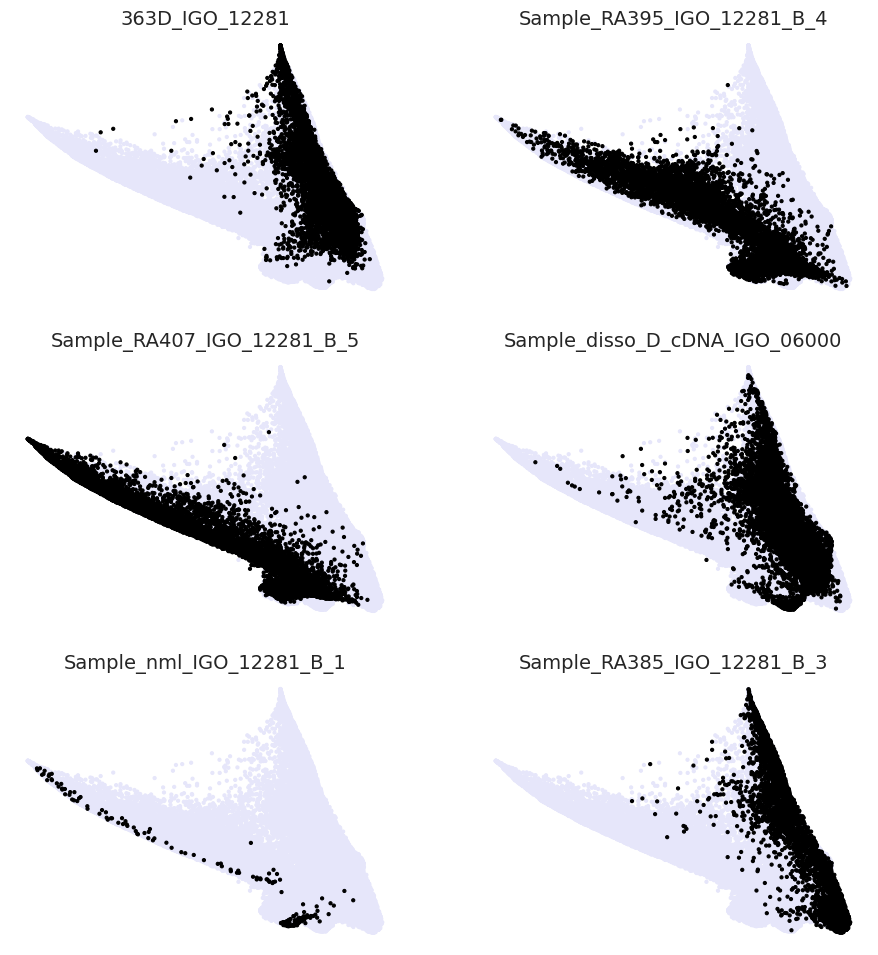

In [22]:
binary_plot(adata.obsm['X_fd_nolog'],adata.obs['sample'], 
            cat_order=['Sample_disso_D_cDNA_IGO_06000',
 '363D_IGO_12281',
 'Sample_RA385_IGO_12281_B_3',
 'Sample_RA407_IGO_12281_B_5',
 'Sample_RA395_IGO_12281_B_4',
 'Sample_nml_IGO_12281_B_1'], 
            colored = True, 
            max_cols = 2
           )


## Clustering

In [ ]:
# import phenograph
# a,b,c = phenograph.cluster(adata.obsm['X_pca_nolog'],k=100)
# adata.obs['cluster'] = a

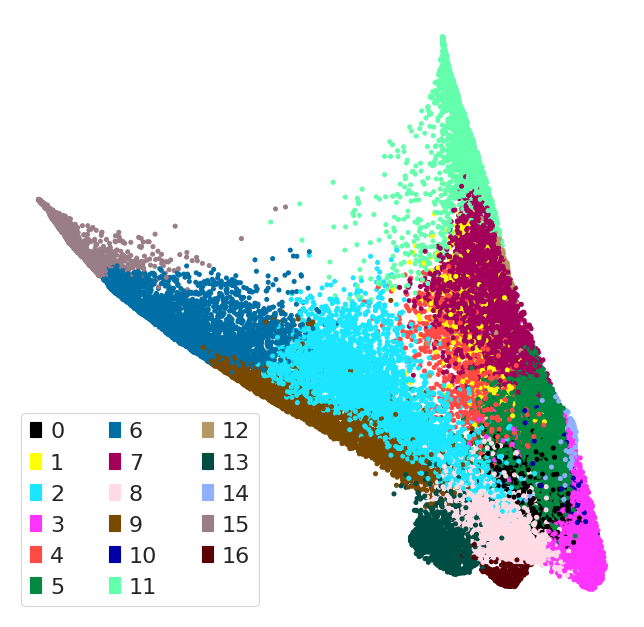

In [26]:
# Visualize Phenograph Clustering
embedding = adata.obsm['X_fd_nolog']
a = np.array(list(map(int,list(adata.obs['cluster'].values))))
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[cluster_colors_long[x] for x in a], s=8)
ax.set_axis_off()

handles = []
for i in set(a):
    handles.append(mpatches.Patch(label=i, color=cluster_colors_long[i]))
plt.legend(handles=handles, ncol=3, fontsize = 16)



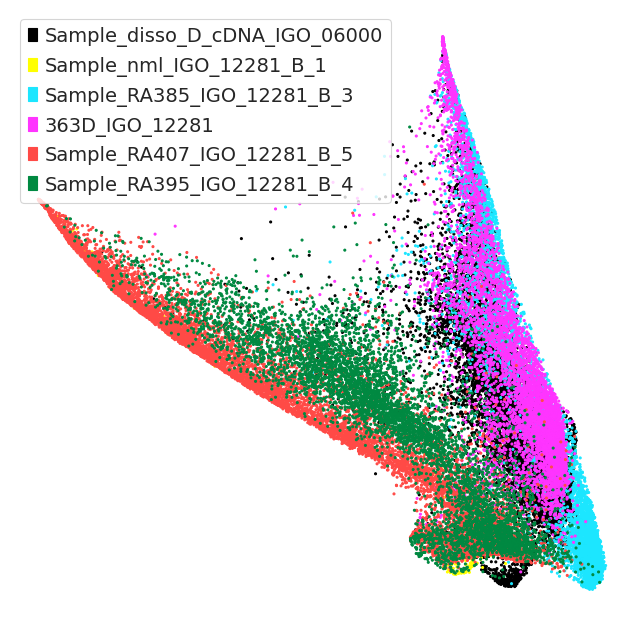

In [27]:
# Visualize Phenograph Clustering
embedding = adata.obsm['X_fd_nolog']
a = adata.obs['sample'].values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[cluster_colors_long[x] for x in pd.factorize(a)[0]], s=2)
ax.set_axis_off()

handles = []
for j,i in enumerate(pd.factorize(a)[1]):
    handles.append(mpatches.Patch(label=i, color=cluster_colors_long[j]))
plt.legend(handles=handles, ncol=1, fontsize = 14)



# Post-batch-correction

In [13]:
adata = sc.read('/data/leslie/gaov/project/synfib_revision/data/forPub/adata_scrna_batchCorrected.h5')
adata.X = adata.layers['lib_norm'].copy()
sc.pp.log1p(adata)

## Batch correction

In [ ]:
# sc.external.pp.harmony_integrate(adata, 'sample', basis='X_pca_nolog', adjusted_basis='X_pca_harmony')


## Visualization

In [ ]:
# fd_layout_corrected = run_fdg(adata.obsm['X_pca_harmony'], edgeW = 0.8, tol=1, gravity = 1)
# adata.obsm['X_fd'] = fd_layout_corrected

## Clustering

#### Selecting k

In [28]:
# import phenograph
# cluster_dict = {}
# for k in [10,20,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500]:
#     a,b,c = phenograph.cluster(adata.obsm['X_pca_harmony'],k=k)
#     cluster_dict[k] = a

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 34.757256746292114 seconds
Jaccard graph constructed in 5.352498531341553 seconds
Wrote graph to binary file in 0.2731015682220459 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.84346
Louvain completed 21 runs in 12.297884464263916 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 55.6531286239624 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 35.79415154457092 seconds
Jaccard graph constructed in 6.626614809036255 seconds
Wrote graph to binary file in 0.48929738998413086 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.807817
After 9 runs, maximum modularity is Q = 0.809074
Louvain completed 29 runs in 31.65577006340027 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 77.74766397476196 seconds
Findin

Louvain completed 21 runs in 210.07931566238403 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 637.5941753387451 seconds
Finding 450 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 41.669596433639526 seconds
Jaccard graph constructed in 550.7940633296967 seconds
Wrote graph to binary file in 10.808548212051392 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.709189
After 2 runs, maximum modularity is Q = 0.71431
Louvain completed 22 runs in 203.00695848464966 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 814.5233929157257 seconds
Finding 500 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 41.300689458847046 seconds
Jaccard graph constructed in 669.3130619525909 seconds
Wrote graph to binary file in 12.653863668441772 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.705244
Af

In [29]:
# from sklearn.metrics.cluster import adjusted_rand_score
# ars_all = []
# for k1 in [10,20,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500]:
#     ars_cur = []
#     for k2 in [10,20,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500]:
#         ars_cur.append(adjusted_rand_score(cluster_dict[k1], cluster_dict[k2]))
#     ars_all.append(ars_cur)
        

<AxesSubplot:>

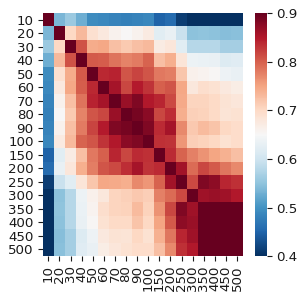

In [35]:
# sns.heatmap(ars_all,  vmax = 0.9, vmin =0.4, cmap = 'RdBu_r', 
#             xticklabels=[10,20,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500],
#             yticklabels=[10,20,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500],
#            )

#### Phenograph

In [13]:
# import phenograph
# a,b,c = phenograph.cluster(adata.obsm['X_pca_harmony'],k=100)
# adata.obs['cluster_harmony_k100'] = a

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 35.502485275268555 seconds
Jaccard graph constructed in 29.221518993377686 seconds
Wrote graph to binary file in 2.613821029663086 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.764642
After 4 runs, maximum modularity is Q = 0.76668
Louvain completed 24 runs in 70.20205307006836 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 141.33781719207764 seconds


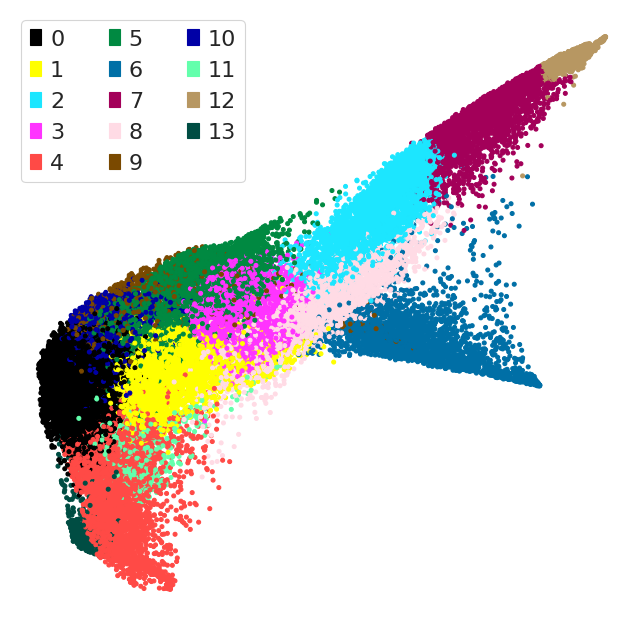

In [29]:
# Visualize Phenograph Clustering
embedding = adata.obsm['X_fd']
a = np.array(list(map(int,list(adata.obs['cluster_harmony_k100'].values))))
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[cluster_colors_long[x] for x in a], s=8)
ax.set_axis_off()

handles = []
for i in set(a):

    handles.append(mpatches.Patch(label=i, color=cluster_colors_long[i]))

plt.legend(handles=handles, ncol=3, fontsize = 16)



Text(0.5, 1.0, 'Cluster Composition')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


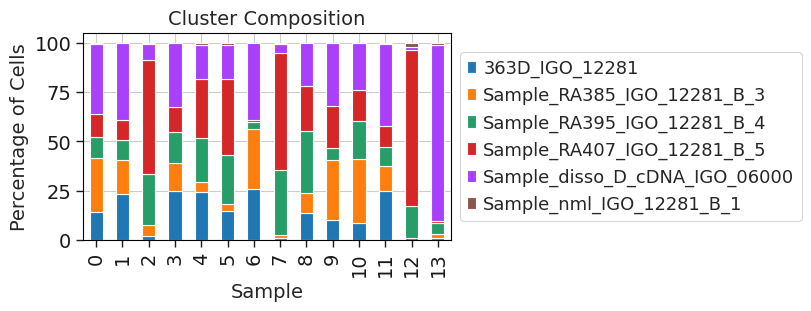

In [30]:
adata.obs['cluster_harmony_k100'] = pd.Categorical(adata.obs['cluster_harmony_k100'])

import matplotlib.colors as colors
proportions_samples = GetCellTypeFraction(np.array(list(adata.obs['cluster_harmony_k100'].values)), adata.obs['sample'])
clust_major_rep = proportions_samples.columns[np.argmax(proportions_samples.values, axis=1)]
proportions_samples2 = proportions_samples.copy()
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(8,3))

proportions_samples2.plot(kind='bar', stacked=True, ax=axes)
axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes.set_xlabel('Sample')
axes.set_ylabel('Percentage of Cells')
axes.set_title('Cluster Composition')


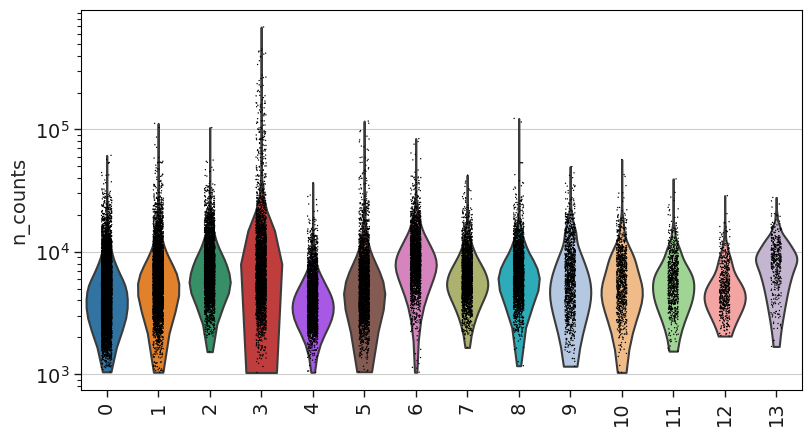

In [33]:
plt.rcParams['figure.figsize'] = [8,5]
adata.obs['cluster_harmony_k100'] = pd.Categorical(adata.obs['cluster_harmony_k100'])
t1 = sc.pl.violin(adata, 'n_counts', groupby='cluster_harmony_k100', size=1, log=True, rotation=90)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


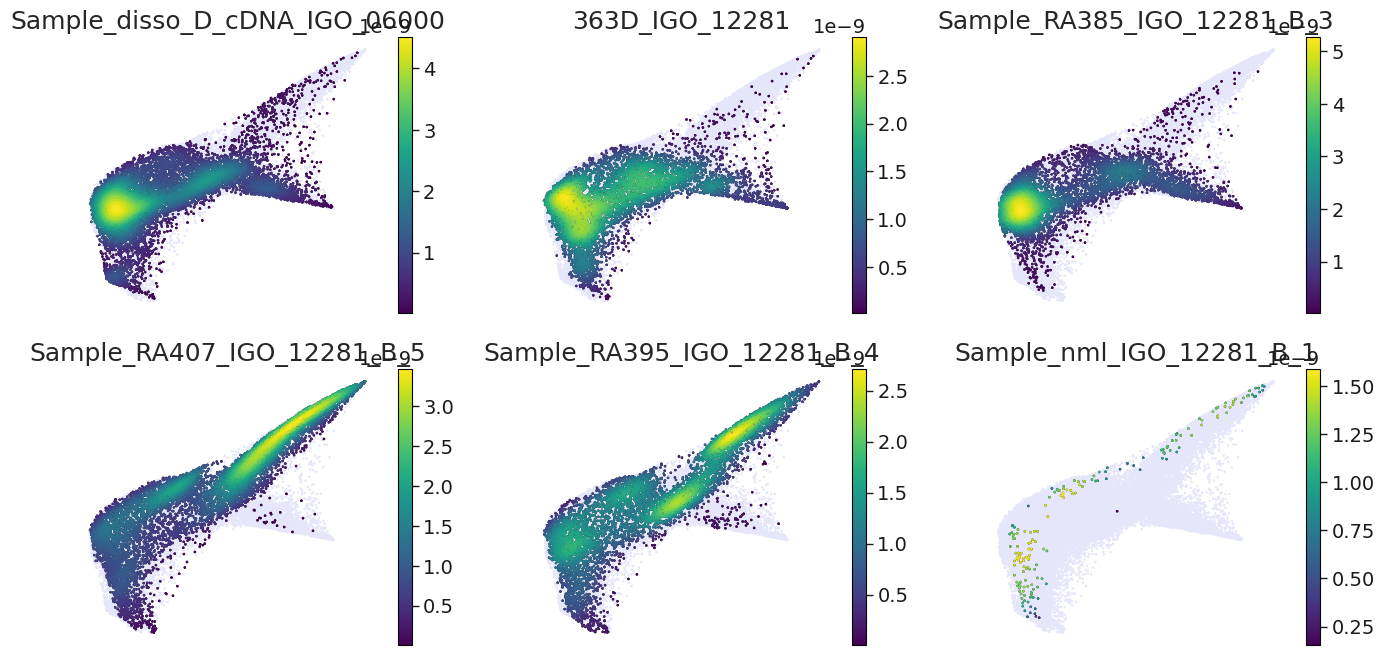

In [34]:
binary_plot(adata.obsm['X_fd'],adata.obs['sample'], 
cat_order=['Sample_disso_D_cDNA_IGO_06000',
  '363D_IGO_12281',
 'Sample_RA385_IGO_12281_B_3',
 'Sample_RA407_IGO_12281_B_5',
 'Sample_RA395_IGO_12281_B_4',
 'Sample_nml_IGO_12281_B_1',
], s = 1
           )


## Fibroblast state assignment

Cluster correlation

In [35]:
adata.X = adata.layers['lib_norm'].copy()
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [36]:
clust_mean = pd.DataFrame(np.array(adata[:,adata.var['highly_variable']].X),columns=adata.var.index[adata.var['highly_variable']]).groupby(adata.obs.cluster_harmony_k100.values).mean()
clust_corr = np.corrcoef(clust_mean)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


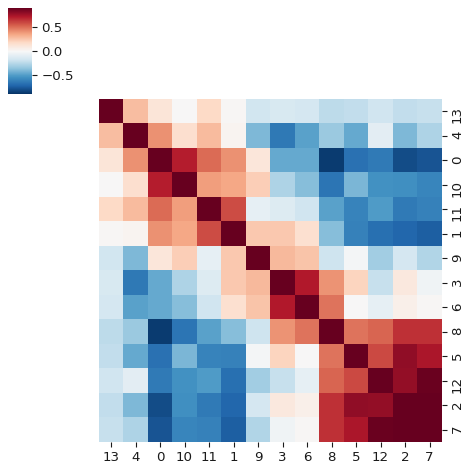

In [37]:
sc.set_figure_params(scanpy=True, fontsize=12)
sns.clustermap(pd.DataFrame(clust_corr).iloc[[13,4,0,10,11,1,9,3,6,8,5,12,2,7]].T.iloc[[13,4,0,10,11,1,9,3,6,8,5,12,2,7]], cmap = 'RdBu_r', vmax = 0.9, vmin = -0.9, 
               figsize=(6,6), metric='sqeuclidean',
               row_cluster=False,col_cluster=False


              )

Define states

In [73]:
adata.obs['subtype_coarse'] = 'Lining'
adata.obs['subtype_coarse'][adata.obs['cluster_harmony_k100'].isin([5, 12, 2, 7, 8, 3, 6])] = 'Lining'
adata.obs['subtype_coarse'][adata.obs['cluster_harmony_k100'].isin([0, 10, 11, 1, 4, 13])] = 'Sublining'


<ipython-input-73-41dad510552c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['subtype_coarse'][adata.obs['cluster_harmony_k100'].isin([5, 12, 2, 7, 8, 3, 6])] = 'Lining'
<ipython-input-73-41dad510552c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['subtype_coarse'][adata.obs['cluster_harmony_k100'].isin([0, 10, 11, 1, 4, 13])] = 'Sublining'


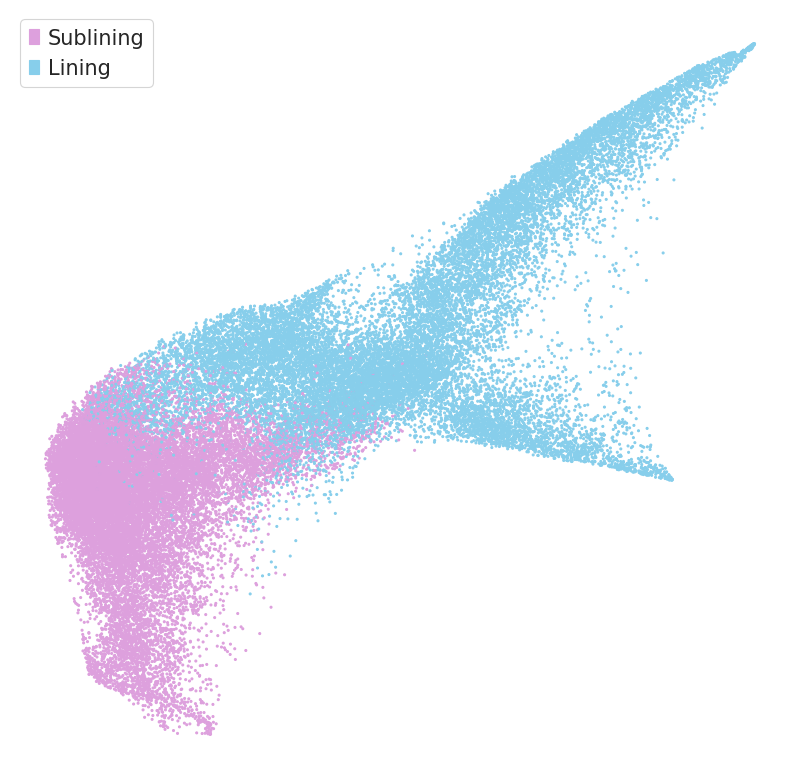

In [85]:
# Visualize Phenograph Clustering
embedding = adata.obsm['X_fd']
a = np.array(adata.obs['subtype_coarse'].values)
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[state_cmap[x] for x in a], s=2)
ax.set_axis_off()

handles = []
for i in set(a):

    handles.append(mpatches.Patch(label=i, color=state_cmap[i]))

plt.legend(handles=handles, ncol=1, fontsize = 15)



In [ ]:
adata.obs['subtype_fine'] = 'Intermediate Lining/Sublining'
adata.obs['subtype_fine'][adata.obs['cluster_harmony_k100'].isin([8])] = 'Intermediate Inflamed/Resting Lining'
adata.obs['subtype_fine'][adata.obs['cluster_harmony_k100'].isin([5, 12, 2, 7])] = 'Resting Lining'
adata.obs['subtype_fine'][adata.obs['cluster_harmony_k100'].isin([4,13])] = 'Resting Sublining'
adata.obs['subtype_fine'][adata.obs['cluster_harmony_k100'].isin([0, 10, 11, 1])] = 'Inflamed Sublining'
adata.obs['subtype_fine'][adata.obs['cluster_harmony_k100'].isin([3,6])] = 'Inflamed Lining'


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


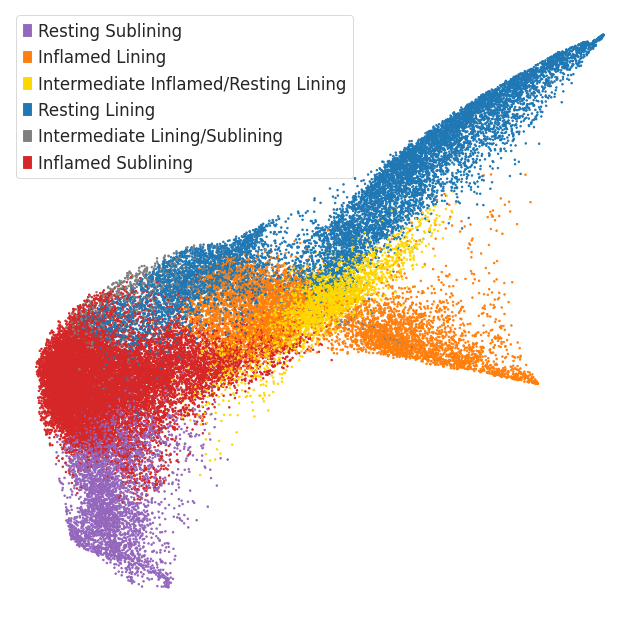

In [38]:
# Visualize Phenograph Clustering
embedding = adata.obsm['X_fd']
a = np.array(adata.obs['subtype_fine'].values)
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embedding[:, 0], embedding[:, 1], 
           c=[state_cmap[x] for x in a], s=2)
ax.set_axis_off()

handles = []
for i in set(a):

    handles.append(mpatches.Patch(label=i, color=state_cmap[i]))

plt.legend(handles=handles, ncol=1, fontsize = 15)



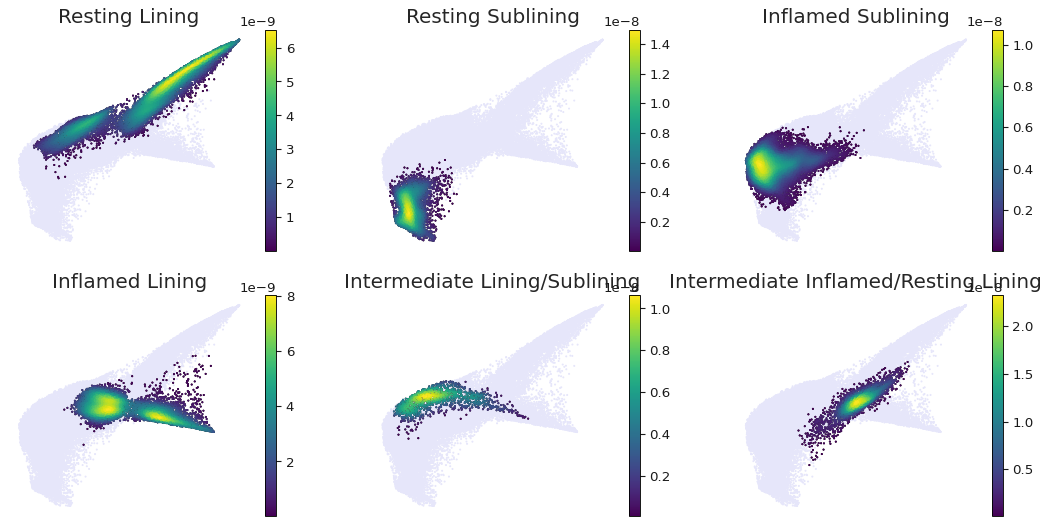

In [39]:
binary_plot(adata.obsm['X_fd'],adata.obs['subtype_fine'], cat_order=['Resting Lining',
 'Resting Sublining',
 'Inflamed Sublining',
 'Inflamed Lining',
 'Intermediate Lining/Sublining','Intermediate Inflamed/Resting Lining'
], s = 1
           )


Text(0, 0.5, 'Percentage of Cells')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
/home/gaov/anaconda3/envs/scanpy/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/gaov/anaconda3/envs/scanpy/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


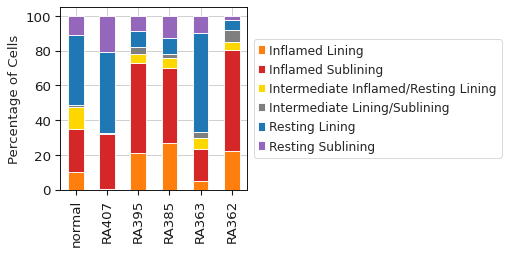

In [40]:
# sample composition of fibroblast subtypes 

adata.obs['subtype_fine'] = pd.Categorical(adata.obs['subtype_fine'])

import matplotlib.colors as colors
proportions_samples = GetCellTypeFraction(np.array(list(adata.obs['sample'].values)), adata.obs['subtype_fine'])
clust_major_rep = proportions_samples.columns[np.argmax(proportions_samples.values, axis=1)]
proportions_samples2 = proportions_samples.copy()
fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(3,3))

proportions_samples2.iloc[[1,4,3,0,2,5]].plot(kind='bar', stacked=True, ax=axes, 
                          color = ['tab:orange', 'tab:red','gold', 'tab:grey','tab:blue','tab:purple'])
axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes.set_xticklabels(['normal','RA407','RA395','RA385','RA363','RA362'])
axes.set_ylabel('Percentage of Cells')


Text(0, 0.5, 'Percentage of Cells')

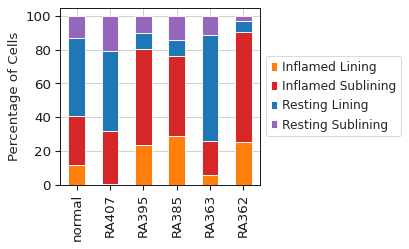

In [41]:
# sample composition of fibroblast subtypes (without intermediate populations)
proportions_samples = GetCellTypeFraction(np.array(list(adata.obs['sample'][['Intermediate' not in x for x in adata.obs['subtype_fine']]].values)), adata.obs['subtype_fine'][['Intermediate' not in x for x in adata.obs['subtype_fine']]])
clust_major_rep = proportions_samples.columns[np.argmax(proportions_samples.values, axis=1)]
proportions_samples2 = proportions_samples.copy()

fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,3))

proportions_samples2.iloc[[1,4,3,0,2,5]].plot(kind='bar', stacked=True, ax=axes, 
                          color = ['tab:orange', 'tab:red','tab:blue','tab:purple'])
axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
axes.set_xticklabels(['normal','RA407','RA395','RA385','RA363','RA362'])
axes.set_ylabel('Percentage of Cells')


## Palantir

In [42]:
def plot_palantir_results(pr_res, tsne):
    n_branches = pr_res.branch_probs.shape[1]
    n_cols = 6
    n_rows = int(np.ceil(n_branches / n_cols))
    fig = plt.figure(figsize=[4 * n_cols, 4 * (n_rows + 2)])
    gs = plt.GridSpec(
        n_rows + 2, n_cols, height_ratios=np.append([0.75, 0.75], np.repeat(1, n_rows))
    )
    cmap = matplotlib.cm.plasma
    # Pseudotime
    ax = plt.subplot(gs[0:2, 1:3])
    c = pr_res.pseudotime[tsne.index]
    ax.scatter(tsne.loc[:, "x"], tsne.loc[:, "y"], s=3, cmap=matplotlib.cm.plasma, c=c)
    normalize = matplotlib.colors.Normalize(vmin=np.min(c), vmax=np.max(c))
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)
    ax.set_axis_off()
    ax.set_title("Pseudotime")

    # Entropy
    ax = plt.subplot(gs[0:2, 3:5])
    c = pr_res.entropy[tsne.index]
    ax.scatter(tsne.loc[:, "x"], tsne.loc[:, "y"], s=3, cmap=matplotlib.cm.plasma, c=c)
    normalize = matplotlib.colors.Normalize(vmin=np.min(c), vmax=np.max(c))
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)
    ax.set_axis_off()
    ax.set_title("Differentiation potential")

    for i, branch in enumerate(pr_res.branch_probs.columns):
        row = int(np.floor(i / n_cols))
        ax = plt.subplot(gs[row + 2, np.remainder(i, n_cols)])
        c = pr_res.branch_probs.loc[tsne.index, branch]
        ax.scatter(
            tsne.loc[:, "x"], tsne.loc[:, "y"], s=3, cmap=matplotlib.cm.plasma, c=c
        )
        normalize = matplotlib.colors.Normalize(vmin=np.min(c), vmax=np.max(c))
        cax, _ = matplotlib.colorbar.make_axes(ax)
        cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)
        ax.set_axis_off()
        

In [83]:
# dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(adata.obsm['X_pca_harmony'][:,0:100]), n_components=15)
# ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=10)
# ms_data.index = adata.obs.index

Determing nearest neighbor graph...


Starting at a sublining cell in the normal sample

In [85]:
start_cell = 'Sample_nml_IGO_12281_B_1_TAGTGTGGTGGAAACG-1-1-0-0-0-0-0'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=1000)


Sampling and flocking waypoints...
Time for determining waypoints: 0.09825255076090494 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 1.558542807896932 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9993
Correlation at iteration 2: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


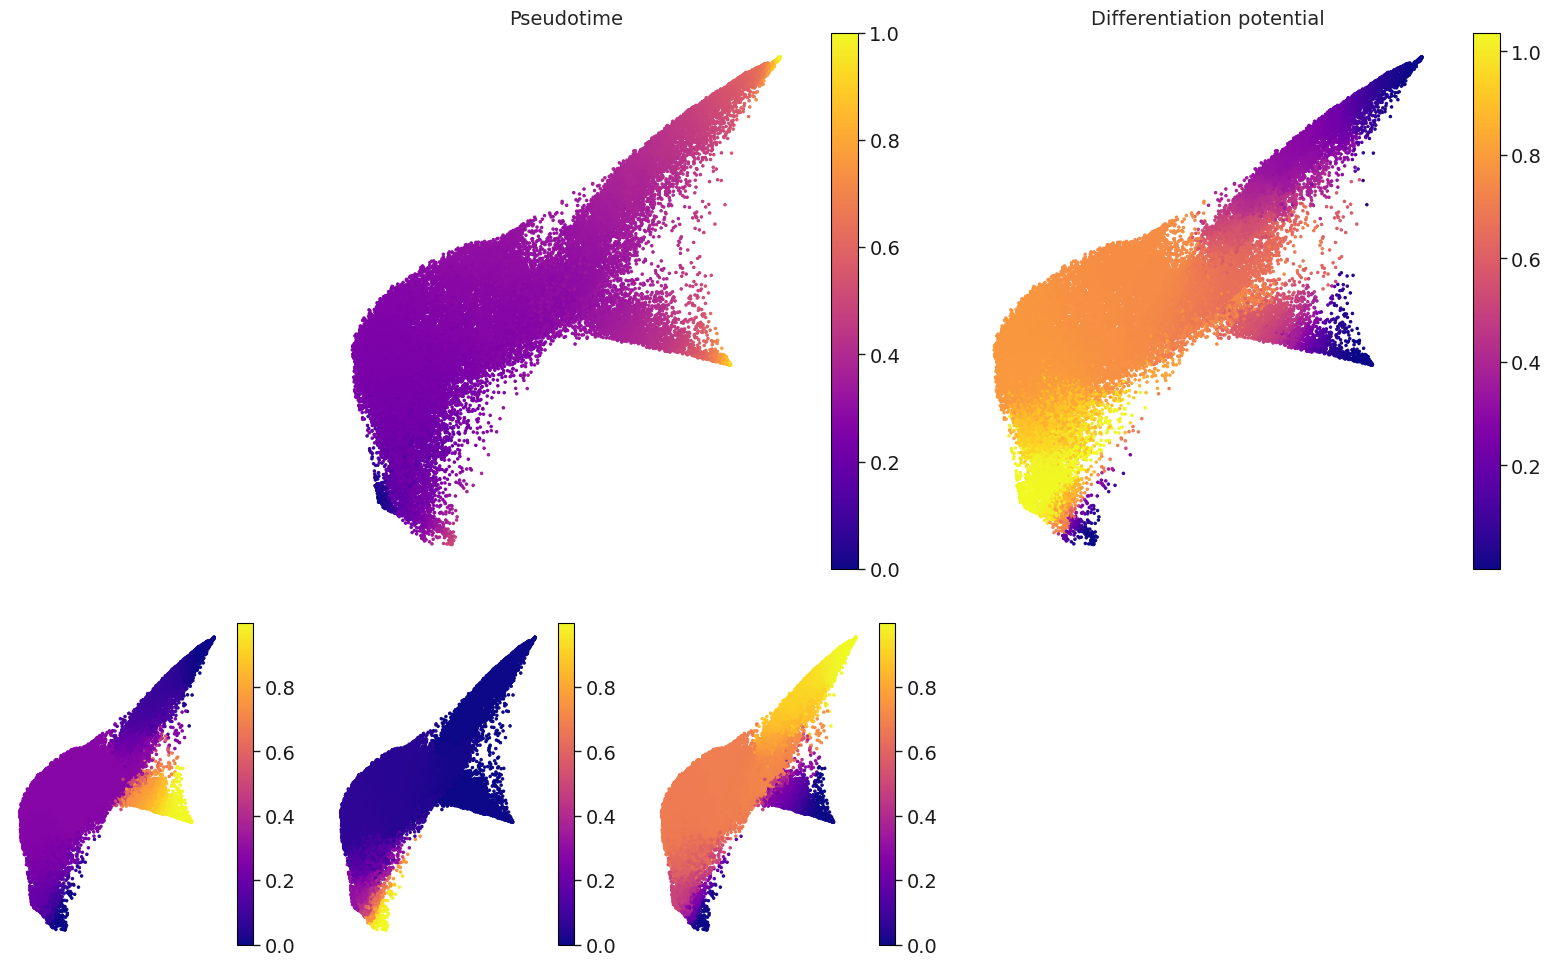

In [87]:
plot_palantir_results(pr_res, pd.DataFrame(adata.obsm['X_fd'], 
                                                         columns= ['x','y'], 
                                                         index = adata.obs.index))


Starting at endpoint 1 in the above result

In [32]:
start_cell = '363D_IGO_12281_TTTAGCTTCCTAGTTT-1-1-0-0'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=1000)


Sampling and flocking waypoints...
Time for determining waypoints: 0.06868026653925578 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 1.317692013581594 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9987
Correlation at iteration 2: 0.9998
Correlation at iteration 3: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


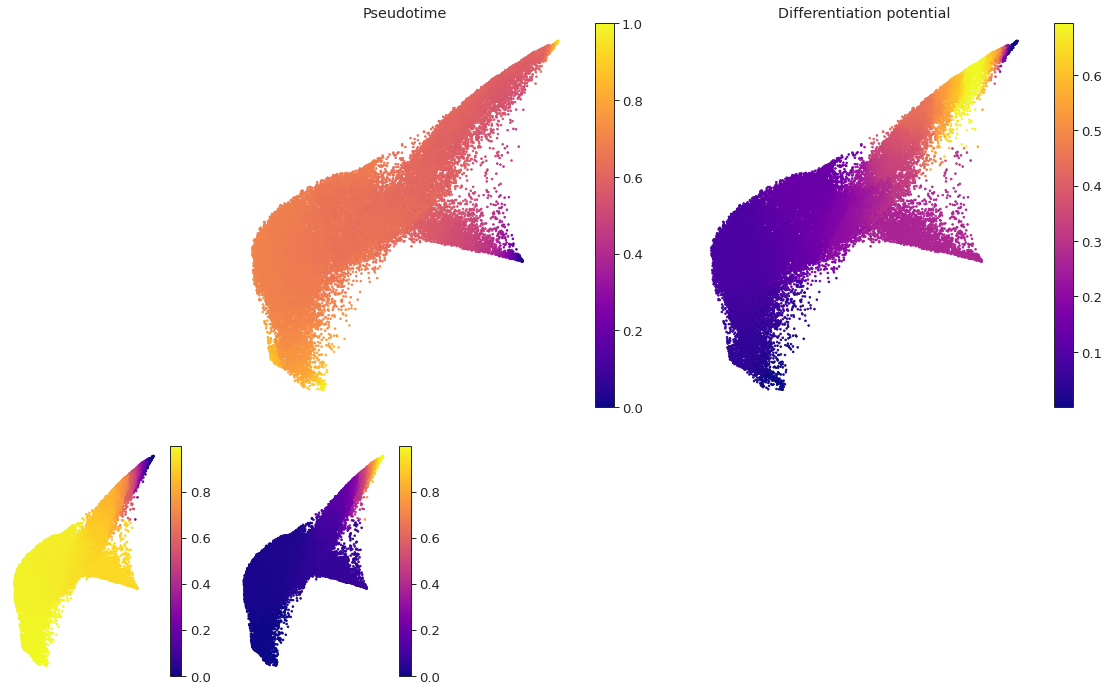

In [34]:
plot_palantir_results(pr_res, pd.DataFrame(adata.obsm['X_fd'], 
                                                         columns= ['x','y'], 
                                                         index = adata.obs.index))


Starting at endpoint 3 in the above result

In [49]:
start_cell = 'Sample_RA407_IGO_12281_B_5_AGAAGGTGTGCTCCAC-1-1-0'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=1000)


Sampling and flocking waypoints...
Time for determining waypoints: 0.0747782309850057 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 1.274630848566691 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9992
Correlation at iteration 2: 0.9999
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


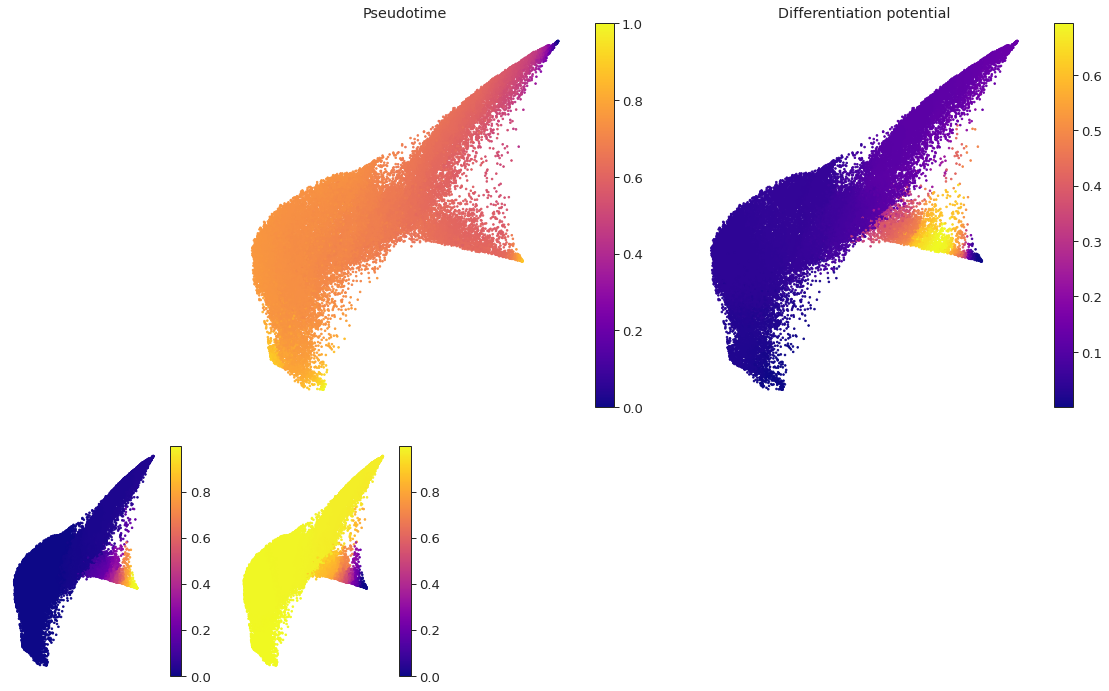

In [50]:
plot_palantir_results(pr_res, pd.DataFrame(adata.obsm['X_fd'], 
                                                         columns= ['x','y'], 
                                                         index = adata.obs.index))


## Signatures

Cell cycle

In [70]:
adata.X = adata.layers['lib_norm'].copy()
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [53]:
cell_cycle_genes = [x.strip() for x in open('/data/leslie/gaov/database/genesets/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [54]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


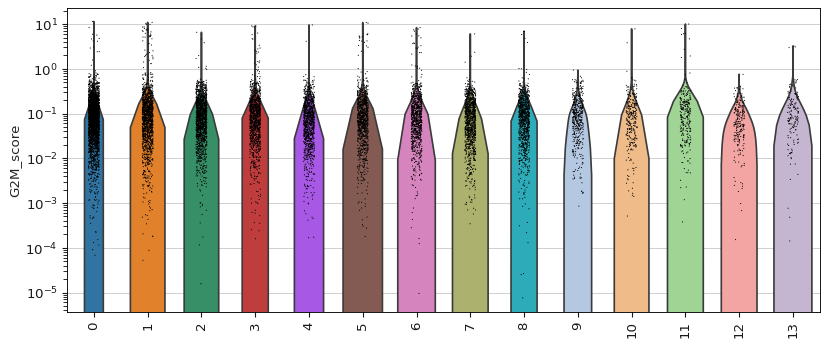

In [57]:
plt.rcParams['figure.figsize'] = [10,5]
adata.obs['cluster_harmony_k100'] = pd.Categorical(adata.obs['cluster_harmony_k100'])
t1 = sc.pl.violin(adata, 'G2M_score', groupby='cluster_harmony_k100', size=1, log=True, cut=0, rotation=90)

# plt.ylim(-0.1,0.5)

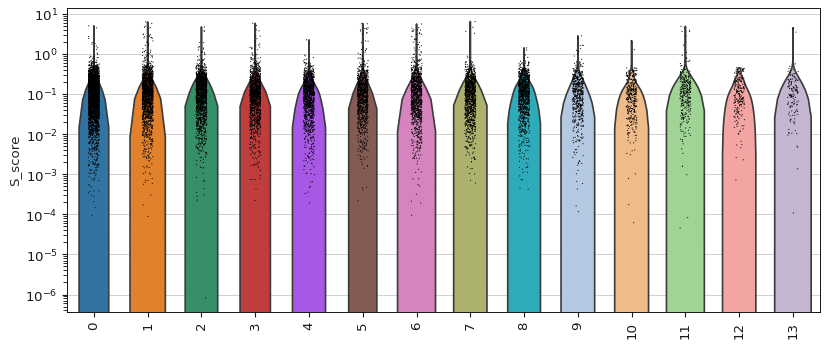

In [56]:
plt.rcParams['figure.figsize'] = [10,5]
adata.obs['cluster_harmony_k100'] = pd.Categorical(adata.obs['cluster_harmony_k100'])
t1 = sc.pl.violin(adata, 'S_score', groupby='cluster_harmony_k100', size=1, log=True, cut=0, rotation=90)

# plt.ylim(-0.1,0.5)

Fibroblast signatures from previous literatures

In [43]:
adata.obs['cluster_harmony_k100'] = pd.Categorical(adata.obs['cluster_harmony_k100'])

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


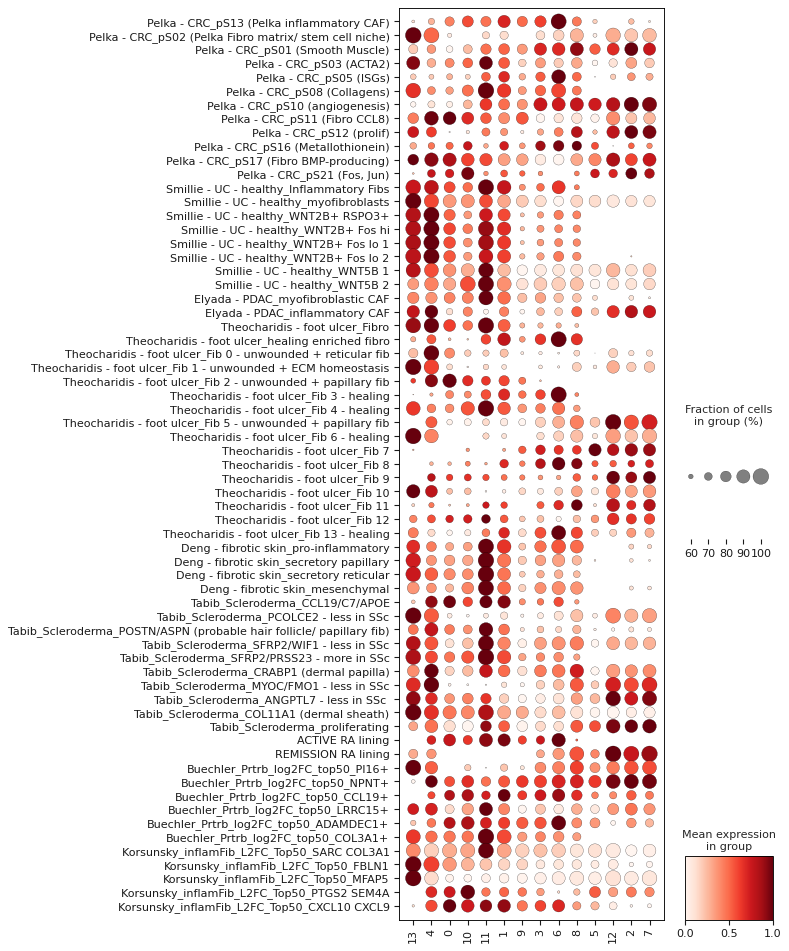

In [44]:
sc.set_figure_params(scanpy=True, fontsize=12)

sc.tl.dendrogram(adata, groupby = 'cluster_harmony_k100', use_rep='X_pca_harmony')
sc.pl.dotplot(adata,
              var_names=[
       'Pelka - CRC_pS13 (Pelka inflammatory CAF)',
       'Pelka - CRC_pS02 (Pelka Fibro matrix/ stem cell niche)',
       'Pelka - CRC_pS01 (Smooth Muscle)', 
       'Pelka - CRC_pS03 (ACTA2)',
       'Pelka - CRC_pS05 (ISGs)', 'Pelka - CRC_pS08 (Collagens)',
       'Pelka - CRC_pS10 (angiogenesis)', 'Pelka - CRC_pS11 (Fibro CCL8)',
       'Pelka - CRC_pS12 (prolif)', 'Pelka - CRC_pS16 (Metallothionein)',
       'Pelka - CRC_pS17 (Fibro BMP-producing)', 'Pelka - CRC_pS21 (Fos, Jun)',
       'Smillie - UC - healthy_Inflammatory Fibs',
       'Smillie - UC - healthy_myofibroblasts',
       'Smillie - UC - healthy_WNT2B+ RSPO3+',
       'Smillie - UC - healthy_WNT2B+ Fos hi',
       'Smillie - UC - healthy_WNT2B+ Fos lo 1',
       'Smillie - UC - healthy_WNT2B+ Fos lo 2',
       'Smillie - UC - healthy_WNT5B 1', 'Smillie - UC - healthy_WNT5B 2',
       'Elyada - PDAC_myofibroblastic CAF', 'Elyada - PDAC_inflammatory CAF',
       'Theocharidis - foot ulcer_Fibro',
       'Theocharidis - foot ulcer_healing enriched fibro',
       'Theocharidis - foot ulcer_Fib 0 - unwounded + reticular fib',
       'Theocharidis - foot ulcer_Fib 1 - unwounded + ECM homeostasis',
       'Theocharidis - foot ulcer_Fib 2 - unwounded + papillary fib',
       'Theocharidis - foot ulcer_Fib 3 - healing',
       'Theocharidis - foot ulcer_Fib 4 - healing',
       'Theocharidis - foot ulcer_Fib 5 - unwounded + papillary fib',
       'Theocharidis - foot ulcer_Fib 6 - healing',
       'Theocharidis - foot ulcer_Fib 7', 'Theocharidis - foot ulcer_Fib 8',
       'Theocharidis - foot ulcer_Fib 9', 'Theocharidis - foot ulcer_Fib 10',
       'Theocharidis - foot ulcer_Fib 11', 'Theocharidis - foot ulcer_Fib 12',
       'Theocharidis - foot ulcer_Fib 13 - healing',
       'Deng - fibrotic skin_pro-inflammatory',
       'Deng - fibrotic skin_secretory papillary',
       'Deng - fibrotic skin_secretory reticular',
       'Deng - fibrotic skin_mesenchymal', 
       'Tabib_Scleroderma_CCL19/C7/APOE',
       'Tabib_Scleroderma_PCOLCE2 - less in SSc',
       'Tabib_Scleroderma_POSTN/ASPN (probable hair follicle/ papillary fib)',
       'Tabib_Scleroderma_SFRP2/WIF1 - less in SSc',
       'Tabib_Scleroderma_SFRP2/PRSS23 - more in SSc',
       'Tabib_Scleroderma_CRABP1 (dermal papilla)',
       'Tabib_Scleroderma_MYOC/FMO1 - less in SSc',
       'Tabib_Scleroderma_ANGPTL7 - less in SSc ',
       'Tabib_Scleroderma_COL11A1 (dermal sheath)',
       'Tabib_Scleroderma_proliferating',
       'ACTIVE RA lining', 'REMISSION RA lining',
       'Buechler_Prtrb_log2FC_top50_PI16+',
       'Buechler_Prtrb_log2FC_top50_NPNT+',
       'Buechler_Prtrb_log2FC_top50_CCL19+',
       'Buechler_Prtrb_log2FC_top50_LRRC15+',
       'Buechler_Prtrb_log2FC_top50_ADAMDEC1+',
       'Buechler_Prtrb_log2FC_top50_COL3A1+',
       'Korsunsky_inflamFib_L2FC_Top50_SARC COL3A1',
       'Korsunsky_inflamFib_L2FC_Top50_FBLN1',
       'Korsunsky_inflamFib_L2FC_Top50_MFAP5',
       'Korsunsky_inflamFib_L2FC_Top50_PTGS2 SEM4A',
       'Korsunsky_inflamFib_L2FC_Top50_CXCL10 CXCL9'
], 
             groupby='cluster_harmony_k100', standard_scale='var', dendrogram=False, dot_min=0.5,
              expression_cutoff=-0.2, 
              swap_axes=True, figsize=(6,15),
                           categories_order = [13,4,0,10,11,1,9,3,6,8,5,12,2,7]
)


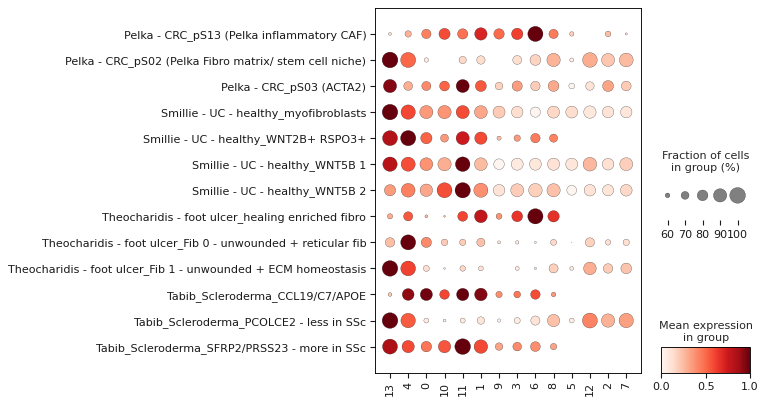

In [87]:
sc.set_figure_params(scanpy=True, fontsize=12)

sc.pl.dotplot(adata, 
              var_names=[
       'Pelka - CRC_pS13 (Pelka inflammatory CAF)',
       'Pelka - CRC_pS02 (Pelka Fibro matrix/ stem cell niche)',
       'Pelka - CRC_pS03 (ACTA2)',
       'Smillie - UC - healthy_myofibroblasts',
       'Smillie - UC - healthy_WNT2B+ RSPO3+',
       'Smillie - UC - healthy_WNT5B 1', 
       'Smillie - UC - healthy_WNT5B 2',
       'Theocharidis - foot ulcer_healing enriched fibro',
       'Theocharidis - foot ulcer_Fib 0 - unwounded + reticular fib',
       'Theocharidis - foot ulcer_Fib 1 - unwounded + ECM homeostasis',
       'Tabib_Scleroderma_CCL19/C7/APOE',
       'Tabib_Scleroderma_PCOLCE2 - less in SSc',
       'Tabib_Scleroderma_SFRP2/PRSS23 - more in SSc',
#        'Buechler_Prtrb_log2FC_top50_PI16+',
#        'Buechler_Prtrb_log2FC_top50_NPNT+',
#        'Buechler_Prtrb_log2FC_top50_CCL19+',
#        'Buechler_Prtrb_log2FC_top50_LRRC15+',
#        'Buechler_Prtrb_log2FC_top50_ADAMDEC1+',
#        'Buechler_Prtrb_log2FC_top50_COL3A1+',
#        'Korsunsky_inflamFib_L2FC_Top50_SARC COL3A1',
#        'Korsunsky_inflamFib_L2FC_Top50_FBLN1',
#        'Korsunsky_inflamFib_L2FC_Top50_MFAP5',
#        'Korsunsky_inflamFib_L2FC_Top50_PTGS2 SEM4A',
#        'Korsunsky_inflamFib_L2FC_Top50_CXCL10 CXCL9'
], 
             groupby='cluster_harmony_k100', standard_scale='var', dendrogram=False, dot_min=0.5,
              expression_cutoff=-0.2, 
              swap_axes=True, figsize=(6,6),
                           categories_order = [13,4,0,10,11,1,9,3,6,8,5,12,2,7]
)

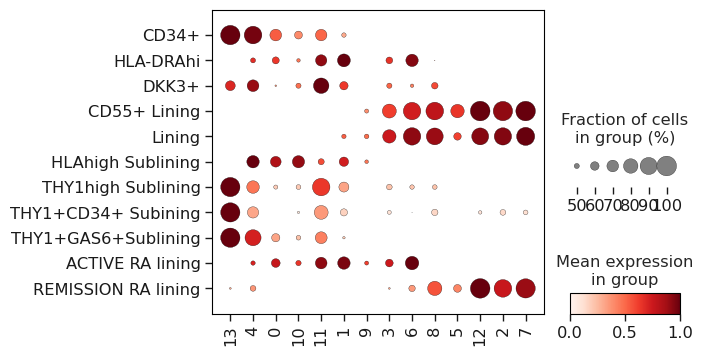

In [51]:
sc.set_figure_params(scanpy=True, dpi=100)
sc.pl.dotplot(adata, var_names= ['CD34+',
 'HLA-DRAhi',
 'DKK3+',
 'CD55+ Lining'] + ['Lining', 'HLAhigh Sublining', 'THY1high Sublining', 'THY1+CD34+ Subining', 'THY1+GAS6+Sublining'] + ['ACTIVE RA lining', 
                                                                                     'REMISSION RA lining'], 
              groupby='cluster_harmony_k100', standard_scale='var', 
             dot_min=0.4, expression_cutoff=0.,
             swap_axes=True, figsize=(6,4),
             dendrogram=False, 
              categories_order = [13,4,0,10,11,1,9,3,6,8,5,12,2,7]             )


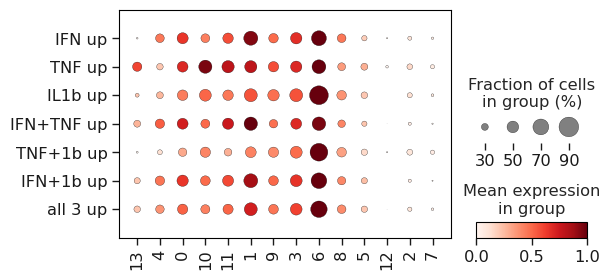

In [52]:
sc.pl.dotplot(adata, 
            var_names=['IFN up', 'TNF up', 'IL1b up', 'IFN+TNF up', 'TNF+1b up', 'IFN+1b up',  'all 3 up'], 
             groupby='cluster_harmony_k100', standard_scale='var', 
              dot_min=0.1, swap_axes=True, figsize=(6,3),
             dendrogram=False, 
              categories_order = [13,4,0,10,11,1,9,3,6,8,5,12,2,7]             )


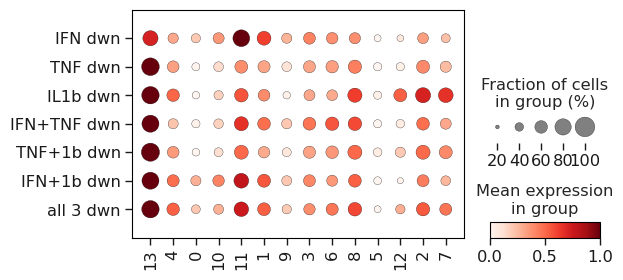

In [53]:
sc.pl.dotplot(adata, 
            var_names=['IFN dwn', 'TNF dwn', 'IL1b dwn', 'IFN+TNF dwn', 'TNF+1b dwn', 'IFN+1b dwn',  'all 3 dwn'], 
             groupby='cluster_harmony_k100', standard_scale='var', 
              dot_min=0.1, swap_axes=True, figsize=(6,3),
             dendrogram=False, 
              categories_order = [13,4,0,10,11,1,9,3,6,8,5,12,2,7]             )


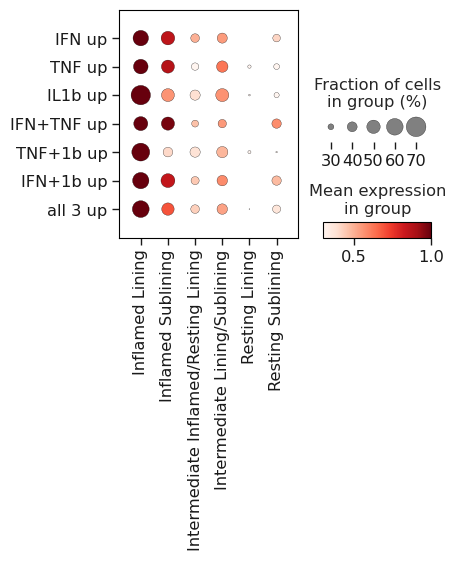

In [54]:

sc.pl.dotplot(adata, 
            var_names=['IFN up', 'TNF up', 'IL1b up', 'IFN+TNF up', 'TNF+1b up', 'IFN+1b up',  'all 3 up'], 
             groupby='subtype_fine', standard_scale='var', 
              dot_min=0.2, swap_axes=True, figsize=(4,3), vmin = 0.3,
#              dendrogram=False, 
#               categories_order = [13,4,0,10,11,1,9,3,6,8,5,12,2,7]             
             )


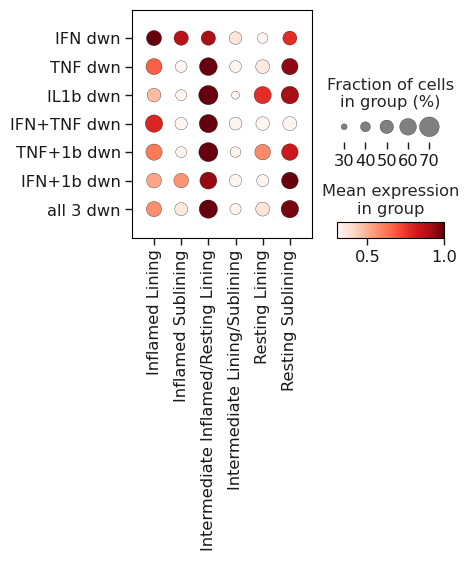

In [55]:

sc.pl.dotplot(adata, 
            var_names=['IFN dwn', 'TNF dwn', 'IL1b dwn', 'IFN+TNF dwn', 'TNF+1b dwn', 'IFN+1b dwn',  'all 3 dwn'], 
             groupby='subtype_fine', standard_scale='var', 
              dot_min=0.2, swap_axes=True, figsize=(4,3), vmin = 0.3,
#              dendrogram=False, 
#               categories_order = [13,4,0,10,11,1,9,3,6,8,5,12,2,7]             
             )


Marker gene expression

In [ ]:
adata.X = adata.layers['lib_norm'].copy()
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [66]:
clust_mean = pd.DataFrame(np.array(adata[:,['CLIC5','HBEGF','PRG4','CD55','CRTAC1','HLA-DRA',
                'CD74','FN1','CXCL1','MMP3','CXCL12','CCL2','APOE','IL6',
                'SFRP1','KAZN','COL3A1','NOTCH3','CDH11','DKK3','POSTN',
                'ASPN','SPARC','CD34','MFAP5','PI16','VCAN','THY1',
                'LRP1B','SLIT2','DCN','CFD','RSPO3']].X),columns=['CLIC5','HBEGF','PRG4','CD55','CRTAC1','HLA-DRA',
                'CD74','FN1','CXCL1','MMP3','CXCL12','CCL2','APOE','IL6',
                'SFRP1','KAZN','COL3A1','NOTCH3','CDH11','DKK3','POSTN',
                'ASPN','SPARC','CD34','MFAP5','PI16','VCAN','THY1',
                'LRP1B','SLIT2','DCN','CFD','RSPO3']).groupby(adata.obs.subtype_fine.values).mean()


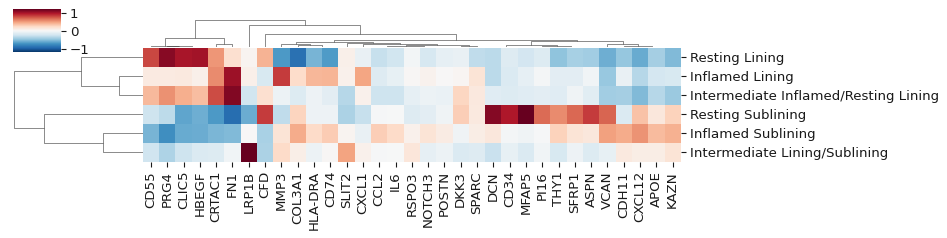

In [67]:
sc.set_figure_params(scanpy=True, fontsize=12)

sns.clustermap(clust_mean, 
               cmap = 'RdBu_r', vmax = 1.2, vmin = -1.2, figsize=(12,3), 
               metric='sqeuclidean', 
#                row_cluster=False
              )


In [58]:
clust_mean = pd.DataFrame(np.array(adata[:,['CLIC5','HBEGF','PRG4','CD55','CRTAC1','HLA-DRA',
                'CD74','FN1','CXCL1','MMP3','CXCL12','CCL2','APOE','IL6',
                'SFRP1','KAZN','COL3A1','NOTCH3','CDH11','DKK3','POSTN',
                'ASPN','SPARC','CD34','MFAP5','PI16','VCAN','THY1',
                'LRP1B','SLIT2','DCN','CFD','RSPO3']].X),columns=['CLIC5','HBEGF','PRG4','CD55','CRTAC1','HLA-DRA',
                'CD74','FN1','CXCL1','MMP3','CXCL12','CCL2','APOE','IL6',
                'SFRP1','KAZN','COL3A1','NOTCH3','CDH11','DKK3','POSTN',
                'ASPN','SPARC','CD34','MFAP5','PI16','VCAN','THY1',
                'LRP1B','SLIT2','DCN','CFD','RSPO3']).groupby(adata.obs.cluster_harmony_k100.values).mean()


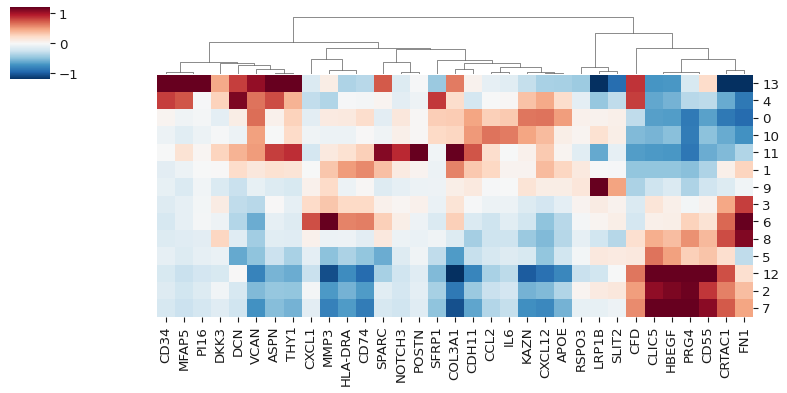

In [59]:
sc.set_figure_params(scanpy=True, fontsize=12)

sns.clustermap(clust_mean.iloc[[13,4,0,10,11,1,9,3,6,8,5,12,2,7]], 
               cmap = 'RdBu_r', vmax = 1.2, vmin = -1.2, figsize=(10,5), 
               metric='correlation', 
               row_cluster=False
              )


In [60]:
clust_mean = pd.DataFrame(np.array(adata[:,[
'NTN4',
'NTN1',
'SEMA3A',
'SEMA3E',
'SEMA3C',
'SEMA5A',
'ANK3',
'SLIT2',
'SLIT3',
'PTGDS',
'NEGR1',
'NAV3',
'TMEM108',
'GPR1',
'THBS4',
'OLFM3',
'CNTN4',
'SPARCL1'
]].X),columns=[
'NTN4',
'NTN1',
'SEMA3A',
'SEMA3E',
'SEMA3C',
'SEMA5A',
'ANK3',
'SLIT2',
'SLIT3',
'PTGDS',
'NEGR1',
'NAV3',
'TMEM108',
'GPR1',
'THBS4',
'OLFM3',
'CNTN4',
'SPARCL1',
]).groupby(adata.obs.cluster_harmony_k100.values).mean()


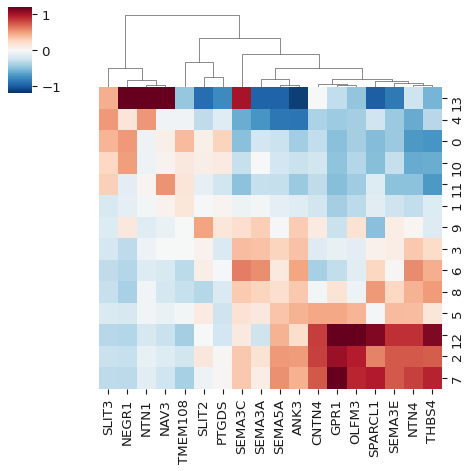

In [61]:
sc.set_figure_params(scanpy=True, fontsize=12)

sns.clustermap(clust_mean.iloc[[13,4,0,10,11,1,9,3,6,8,5,12,2,7]]
               , cmap = 'RdBu_r', vmax = 1.2, vmin = -1.2, figsize=(6,6), 
               metric='correlation',
               row_cluster=False)
